In [12]:
%pip install langchain langgraph replicate


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
os.environ["REPLICATE_API_TOKEN"] ="API_TOKEN" #Put deepseek API token here

In [14]:
from datetime import datetime, timedelta
import re
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_community.llms import Replicate

llm = Replicate(model="meta/meta-llama-3-70b-instruct", model_kwargs={"temperature":1 , "max_length" : 200})
task_logs_key = "logs"

In [15]:
class ScrumState(TypedDict):
    task: str
    logs: List[str]
    pi_table: str
    start_date: str
    end_date: str

def clean_log(text: str) -> str:
    return re.sub(
        r"^(Certainly!?|Sure!?|Of course!?)\s*(Below is|Here('s| is)).*?:?\s*", 
        "", text, flags=re.IGNORECASE
    ).strip()

In [16]:
def customer_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You are the Grocery Store Manager commissioning a new dashboard app. "
        f"Your have to speak as a customer about the task: '{state['task']}'.\n\n"
        "Please provide your requirements:\n"
        "1. Business Goals & Success Metrics\n"
        "2. Primary User Scenarios\n"
        "3. Functional Requirements & Acceptance Criteria\n"
        "4. Data Sources & Integrations\n"
        "5. Prioritization (Must-have vs. Nice-to-have)"
    )
    response = llm.invoke(prompt)
    state[task_logs_key].append(f"[Customer]: {response}")
    return state

def project_manager_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You are the Project Manager. Speak as a project Manager to the Task: '{state['task']}'.\n"
        "Provide:\n"
        "1. Business Objectives & KPIs\n"
        "2. Scope Definition\n"
        "3. Work Breakdown Structure\n"
        "4. Milestones & Timeline Estimates\n"
        "5. Resource & Role Assignments\n"
        "6. Dependencies & Risks\n"
        "7. Communication Plan"
    )
    response = llm.invoke(prompt)
    state[task_logs_key].append(f"[Project Manager]: {response}")
    return state

def analyst_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You are the Business Analyst. Speak as a Business Analyst based on the Task: '{state['task']}'.\n"
        "Provide analysis:\n"
        "1. Bridging the Gap\n"
        "2. Data Analysis & Interpretation\n"
        "3. Process Improvement\n"
        "4. Requirements Documentation\n"
        "5. Solution Design & Feasibility\n"
        "6. Stakeholder Communication\n"
        "7. Risks & Mitigations\n"
        "8. Effort & Impact Estimation"
    )
    response = llm.invoke(prompt)
    state[task_logs_key].append(f"[Business Analyst]: {response}")
    return state

In [17]:
def designer_node(state: ScrumState) -> ScrumState:
    ba_logs = "\n".join(
        log for log in state[task_logs_key] if log.startswith("[Business Analyst]")
    )
    prompt = (
        f"You are the UI/UX Designer. Speak as a UI/UX  Designer working on this taskTask: '{state['task']}'.\n\n"
        f"Refer to this analysis:\n{ba_logs}\n\n"
        "Design Plan:\n"
        "1. Screen Definitions\n"
        "2. User Flows\n"
        "3. UI Components\n"
        "4. UX Decisions\n"
        "5. Wireframe Sketches (Textual)"
    )
    response = llm.invoke(prompt)
    state[task_logs_key].append(f"[UI/UX Designer]: {response}")
    return state

def scrum_master_node(state: ScrumState) -> ScrumState:
    start = state.get("start_date", "TBD")
    end = state.get("end_date", "TBD")
    prompt = (
        f"You are the Scrum Master. You are a Scrum Master where the product manager has  given the task of the customer which is Task: '{state['task']}'\n"
        f"Sprint Duration: {start} to {end}\n"
        "Create a Sprint Backlog:\n"
        "- Sprint Goal\n"
        "- Backlog Items\n"
        "- Role Assignments\n"
        "- Story Points\n"
        "- Timeline & Ceremonies"
    )
    response = llm.invoke(prompt)
    state[task_logs_key].append(f"[Scrum Master]: {response}")
    return state

def developer_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You are the Developer. The Task from the customer is as follows: '{state['task']}'.\n"
        "Provide implementation details about:\n"
        "1. Architecture & Tech Stack\n"
        "2. Implementation Steps\n"
        "3. Dependencies & Risks\n"
        "4. Best Practices"
    )
    response = llm.invoke(prompt)
    state[task_logs_key].append(f"[Developer]: {response}")
    return state


In [18]:
def writer_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You are the Technical Writer. The task from the customer is Task: '{state['task']}'.\n"
        "Create outlines for:\n"
        "- End-User Guide\n"
        "- API Reference\n"
        "- Onboarding FAQs"
    )
    response = llm.invoke(prompt)
    state[task_logs_key].append(f"[Technical Writer]: {response}")
    return state

def qa_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You are the QA Engineer. This is the task from the customer and requirements passed down by Product manager: '{state['task']}'.\n"
        "Provide Test Plan:\n"
        "- Strategy & Scope\n"
        "- Test Cases\n"
        "- Validation Criteria"
    )
    response = llm.invoke(prompt)
    state[task_logs_key].append(f"[QA Engineer]: {response}")
    return state


def standup_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You're facilitating Daily Stand-up for: '{state['task']}'.\n"
        "Summarize:\n"
        "- Yesterday's work\n"
        "- Today’s plan\n"
        "- Blockers"
    )
    response = llm.invoke(prompt)
    state[task_logs_key].append(f"[Stand-up]: {response}")
    return state

def sprint_review_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"Sprint Review for: '{state['task']}'.\n"
        "List:\n"
        "- Completed Work\n"
        "- Demo Highlights\n"
        "- Feedback"
    )
    response = llm.invoke(prompt)
    state[task_logs_key].append(f"[Sprint Review]: {response}")
    return state

In [19]:
def retrospective_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"Retrospective for: '{state['task']}'.\n"
        "List:\n"
        "- 3 Things That Went Well\n"
        "- 3 Areas for Improvement"
    )
    response = llm.invoke(prompt)
    state[task_logs_key].append(f"[Retrospective]: {response}")
    return state


def pi_planning_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"PI Planning for: '{state['task']}'.\n"
        "Output markdown table: Objective | Team | Duration (weeks)"
    )
    response = llm.invoke(prompt)
    state[task_logs_key].append(f"[PI Planning]:\n{response}")
    state["pi_table"] = response
    return state

In [20]:
workflow = StateGraph(ScrumState)

workflow.add_node("customer", RunnableLambda(customer_node))
workflow.add_node("project_manager", RunnableLambda(project_manager_node))
workflow.add_node("analyst", RunnableLambda(analyst_node))
workflow.add_node("designer", RunnableLambda(designer_node))
workflow.add_node("scrum_master", RunnableLambda(scrum_master_node))
workflow.add_node("developer", RunnableLambda(developer_node))
workflow.add_node("qa", RunnableLambda(qa_node))
workflow.add_node("writer", RunnableLambda(writer_node))
workflow.add_node("standup", RunnableLambda(standup_node))
workflow.add_node("sprint_review", RunnableLambda(sprint_review_node))
workflow.add_node("retrospective", RunnableLambda(retrospective_node))
workflow.add_node("pi_planning", RunnableLambda(pi_planning_node))




In [21]:
workflow.add_edge("customer", "project_manager")
workflow.add_edge("project_manager", "analyst")
workflow.add_edge("analyst", "designer")
workflow.add_edge("designer", "scrum_master")
workflow.add_edge("scrum_master", "developer")
workflow.add_edge("developer", "qa")
workflow.add_edge("qa", "writer")
workflow.add_edge("writer", "standup")
workflow.add_edge("standup", "sprint_review")
workflow.add_edge("sprint_review", "retrospective")
workflow.add_edge("retrospective", "pi_planning")

workflow.set_entry_point("customer")
workflow.add_edge("pi_planning", END)

scrum_graph = workflow.compile()

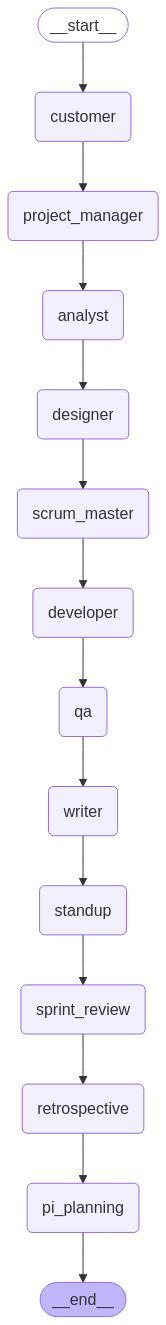

In [22]:
from IPython.display import Image, display

try:
    display(Image(scrum_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph rendering failed. Make sure required packages are installed.")
    print(f"Error: {e}")


In [23]:
def colored(role: str, text: str) -> str:
    colors = {
        "Customer": "\033[94m", "Project Manager": "\033[96m", "Business Analyst": "\033[92m",  
        "UI/UX Designer": "\033[95m", "Scrum Master": "\033[93m", "Developer": "\033[91m",  
        "QA Engineer": "\033[90m", "Technical Writer": "\033[38;5;208m",  
        "Stand-up": "\033[33m", "Sprint Review": "\033[36m",  
        "Retrospective": "\033[35m", "PI Planning": "\033[1;32m",
    }
    reset = "\033[0m"
    return f"{colors.get(role, '')}{text}{reset}"

In [24]:
num_sprints = 2
sprint_length_days = 14
break_between_sprints = 1
base_start_date = datetime(2025, 4, 18)

sprint_results = []
for i in range(num_sprints):
    sprint_start = base_start_date + timedelta(days=i * (sprint_length_days + break_between_sprints))
    sprint_end = sprint_start + timedelta(days=sprint_length_days)
    state = {
        "task": "Design a grocery-store dashboard app with real-time analytics",
        "logs": [],
        "pi_table": "",
        "start_date": sprint_start.strftime("%Y-%m-%d"),
        "end_date": sprint_end.strftime("%Y-%m-%d")
    }
    final_state: ScrumState = {}
    for step in scrum_graph.stream(state):
        for _, out in step.items():
            final_state = out
    sprint_results.append((i, state, final_state))

In [25]:
for i, state, final_state in sprint_results:
    header = f"=== Sprint {i+1}: {state['start_date']} to {state['end_date']} ==="
    print(colored("PI Planning", f"\n{header}"))
    for log in final_state["logs"]:
        role = log.split("]", 1)[0].strip("[")
        content = clean_log(log.split("]:", 1)[1].strip())
        print(colored(role, f"\n[{role}]:\n{content}"))


=== Sprint 1: 2025-04-18 to 2025-05-02 ===

[Customer]:
I'm thrilled to provide my requirements for the new grocery-store dashboard app. Here's what I need:

**1. Business Goals & Success Metrics:**

* **Business Goals:**
	+ Improve inventory management and reduce stockouts/overstocking by 20%.
	+ Increase sales by 15% through data-driven promotions and pricing strategies.
	+ Enhance customer satisfaction by 25% through better in-store experience and personalized offers.
* **Success Metrics:**
	+ Inventory turnover rate
	+ Sales growth
	+ Customer satisfaction ratings (based on surveys and feedback)
	+ Average basket size
	+ Supply chain efficiency

**2. Primary User Scenarios:**

* **Scenario 1:** As a store manager, I want to monitor real-time sales data to identify top-selling items, sales trends, and areas of opportunity, so I can adjust inventory and promotions accordingly.
* **Scenario 2:** As a department manager, I want to track inventory levels, stockout rates, and supplier p

In [26]:
for i, state, final_state in sprint_results:
    ceremonies_header = f"--- Ceremonies ({state['start_date']} to {state['end_date']}) ---"
    print(colored("Stand-up", f"\n{ceremonies_header}"))
    for ceremony in ["Stand-up", "Sprint Review", "Retrospective"]:
        for log in final_state["logs"]:
            if log.startswith(f"[{ceremony}]"):
                content = clean_log(log.split("]:", 1)[1].strip())
                print(colored(ceremony, f"\n[{ceremony}]:\n{content}"))


--- Ceremonies (2025-04-18 to 2025-05-02) ---

[Stand-up]:
Let's get started with the Daily Stand-up for the "Design a grocery-store dashboard app with real-time analytics" project.

**Yesterday's Work:**

* Emma, our UI/UX designer, completed the wireframing of the dashboard's main page, incorporating real-time sales data and customer traffic analytics.
* Jack, our backend developer, set up the API connections to fetch real-time data from the grocery store's point-of-sale system.
* Sarah, our frontend developer, started building the data visualization components for the dashboard, using D3.js and React.

**Today's Plan:**

* Emma will refine the wireframes for the inventory management and supply chain analytics pages.
* Jack will work on implementing data caching to improve the API's response time and reduce the load on the point-of-sale system.
* Sarah will focus on integrating the data visualization components with the API, ensuring seamless data updates and interactions.

**Blocke

In [27]:
for i, state, final_state in sprint_results:
    planning_header = f"--- PI Planning ({state['start_date']} to {state['end_date']}) ---"
    print(colored("PI Planning", f"\n{planning_header}"))
    pi_content = final_state.get("pi_table", "No data available")
    print(colored("PI Planning", f"\n📊 PI Planning Table:\n{pi_content}\n"))


--- PI Planning (2025-04-18 to 2025-05-02) ---

📊 PI Planning Table:


Here is a sample PI planning for the project "Design a grocery-store dashboard app with real-time analytics":

| Objective | Team | Duration (weeks) |
| --- | --- | --- |
| **Sprint 1: Research and Planning** | | 2 |
| Conduct market research and competitor analysis | Data Analyst | 1 |
| Define project scope, goals, and requirements | Product Owner | 1 |
| Identify key performance indicators (KPIs) for the dashboard | Business Analyst | 1 |
| **Sprint 2: Data Ingestion and Storage** | | 3 |
| Design and implement data ingestion pipeline | Data Engineer | 2 |
| Set up data storage solutions (e.g. database, data warehouse) | Data Engineer | 1 |
| **Sprint 3: Dashboard Design and Development** | | 4 |
| Design the user interface and user experience of the dashboard | UX Designer | 2 |
| Develop the dashboard frontend using a framework (e.g. React, Angular) | Frontend Developer | 2 |
| **Sprint 4: Real-time Analytics 